In [1]:
# modules required for handling dataframes
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import itertools
import seaborn as sns
from decimal import Decimal

In [2]:
#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot_k2(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='seq_length_k2', 
                                            index=rank, 
                                            columns='superkingdom_k2', 
                                            aggfunc='sum', 
                                            fill_value=0)
    pivot_table.columns.name = None
    pivot_table = pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)
    return pivot_table


#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot_minimap(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='seqlen', 
                                            index=rank, 
                                            columns='kingdom', 
                                            aggfunc='count', 
                                            fill_value=0)
    pivot_table.columns.name = None
    pivot_table = pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)
    return pivot_table

def add_df_headers(df, header_list):
    df.columns = header_list

def trim_df_columns(df,column_list):
    df.drop(columns=column_list, inplace=True)
    
def subset_blast_df_evalue(blast_df, evalue):
    subset_blast_df = blast_df[blast_df.log_evalue > int(evalue)]
    return subset_blast_df

def subset_blast_df_pident(blast_df, pident):
    subset_blast_df = blast_df[blast_df.pident > int(pident)]
    return subset_blast_df

In [3]:
# Define some global variables.
sourcedir = '/home/yiheng/MinION_data/' # the directory where all the documents of each sequencing run are stored.
basedir = os.path.join(sourcedir, 'mock_com', 'nanopore','amplicon')
genera_in_mock = ['Aspergillus','Blastobotrys','Candida','Diutina', 'Nakaseomyces', 'Clavispora','Cryptococcus','Cyberlindnera',
'Debaryomyces','Geotrichum','Kluyveromyces','Kodamaea','Lomentospora','Magnusiomyces','Meyerozyma','Pichia',
'Rhodotorula','Scedosporium','Trichophyton', 'Trichosporon', 'Wickerhamomyces','Yarrowia','Zygoascus', 'Purpureocillium']

In [4]:
# There are quite few if conditions in the function. This is because the final dataframe (tab file) are not consistantly generated.
# This function set an example of how to deal with inconsistant dataframe.
# I could clean up the final tab file from each analysis because I generated those files,
# but this kind of conditions can be useful if the tab file were generated by others.
def get_tab_df(barcode, db, algorithm):
    if db == 'uniteITS' and algorithm == 'minimap':
        tab_file = os.path.join(basedir, 'barcode%s' % barcode, 'barcode%s.UNITEITSdb_%s.tab' % (barcode, algorithm))
    else:
        tab_file = os.path.join(basedir, 'barcode%s' % barcode, 'barcode%s.%sdb_%s.tab' % (barcode, db, algorithm))
        
    tab_df = pd.read_csv(tab_file, sep='\t', index_col=0)
    return tab_df

def calculate_precision_rate(barcode, algorithm, db):      
    tab_df = get_tab_df(barcode, db, algorithm)
    if algorithm == 'k2':
        tab_df_in_mock = tab_df[tab_df.genus_k2.isin(genera_in_mock)]
        # Note that here I used number of reads instead of total length to calculate precision rate.
        # This is different with metagenomics dataset, and it is because this is the common way of doing it.
        # It is because amplicons are supposed to be the same length.
        precision_rate = len(tab_df_in_mock.read_id_k2)/len(tab_df.read_id_k2)
    else:
        tab_df_in_mock = tab_df[tab_df.genus.isin(genera_in_mock)]
        precision_rate = len(tab_df_in_mock.seqid)/len(tab_df.seqid)
    return precision_rate   

# Here is the function to calculate recall rate. ONLY FOR MINIMAP RESULT.
# This is because the kraken result is already shown in the kraken log record. Just need to note down the numbers.
def calculate_minimap_recall_rate(barcode, db):
    tab_df = get_tab_df(barcode, db, 'minimap')
    
    if barcode == '01':
        recall_rate = len(tab_df)/26212
    elif barcode == '02':
        recall_rate = len(tab_df)/20163
    elif barcode == '05':
        recall_rate = len(tab_df)/26680
    elif barcode == '06':
        recall_rate = len(tab_df)/18273
    elif barcode == '09':
        recall_rate = len(tab_df)/31826
    elif barcode == '10':
        recall_rate = len(tab_df)/15502
    else:
        print('barcode is wrong, please select another barcode.')
    return recall_rate

In [5]:
# Now make the recall rate dictionary for k2 analysis.
# These numbers are all copied straightway from the standard output of kraken analysis.
barcode_list = ['01','02','05','06','09','10']
recall_rate_list_ITS = [0.8852, 0.8466, 0.9445, 0.8285, 0.8730, 0.8096]
recall_rate_list_18S = [0.8730, 0.8311, 0.9348, 0.8191, 0.8647, 0.8030]
recall_rate_list_28S = [0.8672, 0.8136, 0.9265, 0.8022, 0.8585, 0.7854]
recall_rate_list_uniteITS = [0.8956, 0.8602, 0.9512, 0.8454, 0.8827, 0.8275]
recall_rate_list_unite99ITS = [0.8942, 0.8599, 0.9511, 0.8439, 0.8820, 0.8255]

k2_recall_dict_ITS = {key: value for (key, value) in zip(barcode_list, recall_rate_list_ITS)}
k2_recall_dict_18S = {key: value for (key, value) in zip(barcode_list, recall_rate_list_18S)}
k2_recall_dict_28S = {key: value for (key, value) in zip(barcode_list, recall_rate_list_28S)}
k2_recall_dict_uniteITS = {key: value for (key, value) in zip(barcode_list, recall_rate_list_uniteITS)}
k2_recall_dict_unite99ITS = {key: value for (key, value) in zip(barcode_list, recall_rate_list_unite99ITS)}

def get_k2_recall_rate(barcode, db):
    if db == 'ITS':
        recall_rate = k2_recall_dict_ITS[barcode]
        return recall_rate
    elif db == '18S':
        recall_rate = k2_recall_dict_18S[barcode]
        return recall_rate
    elif db == '28S':
        recall_rate = k2_recall_dict_28S[barcode]
        return recall_rate
    elif db == 'uniteITS':
        recall_rate = k2_recall_dict_uniteITS[barcode]
        return recall_rate
    elif db == 'unite99ITS':
        recall_rate = k2_recall_dict_unite99ITS[barcode]
        return recall_rate
    else:
        print("No analysis has been done for this database. Please change database name within 'ITS', '18S', '28S', 'uniteITS'")
    #return recall_rate

In [6]:
def calculate_average_precision(sample, algorithm, db):
    if sample == 'IE':
        average_precision_rate = (calculate_precision_rate('01', '%s' % algorithm, '%s' % db) + 
                                  calculate_precision_rate('05', '%s' % algorithm, '%s' % db) + 
                                  calculate_precision_rate('09', '%s' % algorithm, '%s' % db))/3
        return average_precision_rate
    elif sample == 'MC':
        average_precision_rate = (calculate_precision_rate('02', '%s' % algorithm, '%s' % db) + 
                                  calculate_precision_rate('06', '%s' % algorithm, '%s' % db) + 
                                  calculate_precision_rate('10', '%s' % algorithm, '%s' % db))/3
        return average_precision_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")
        
def calculate_average_precision_all_algorithm(sample, db):
    if sample == 'IE' or sample == 'MC':
        average_precision_rate = (calculate_average_precision(sample, 'minimap', db) + calculate_average_precision(sample, 'k2', db))/2
        return average_precision_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")

In [7]:
def calculate_average_recall_minimap(sample, db):
    if sample == 'IE':
        average_recall_rate = (calculate_minimap_recall_rate('01', '%s' % db) +
                                  calculate_minimap_recall_rate('05', '%s' % db) +
                                  calculate_minimap_recall_rate('09', '%s' % db))/3
        return average_recall_rate
    elif sample == 'MC':
        average_recall_rate = (calculate_minimap_recall_rate('02', '%s' % db) + 
                                  calculate_minimap_recall_rate('06', '%s' % db) + 
                                  calculate_minimap_recall_rate('10', '%s' % db))/3
        return average_recall_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")

def calculate_average_recall_k2(sample, db):
    if sample == 'IE':
        average_recall_rate = (get_k2_recall_rate('01', '%s' % db) +
                               get_k2_recall_rate('05', '%s' % db) +
                               get_k2_recall_rate('09', '%s' % db))/3
        return average_recall_rate
    elif sample == 'MC':
        average_recall_rate = (get_k2_recall_rate('02', '%s' % db) +
                               get_k2_recall_rate('06', '%s' % db) +
                               get_k2_recall_rate('10', '%s' % db))/3
        return average_recall_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")
        
def calculate_average_recall_all_algorithm(sample, db):
    if sample == 'IE' or sample == 'MC':
        average_recall_rate = (calculate_average_recall_k2(sample, db) + calculate_average_recall_minimap(sample, db))/2
        return average_recall_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")

In [8]:
barcodes_IE = ['01', '05', '09']
barcodes_MC = ['02', '06', '10']
algorithms = ['minimap', 'k2']
db_list = ['ITS', 'unite99ITS', '18S', '28S']

In [9]:
precision_rate_list_IE = []
for x in itertools.product(algorithms, db_list, barcodes_IE):
    #print(x)
    precision_rate_list_IE.append(calculate_precision_rate(x[2], x[0], x[1]))

In [10]:
precision_rate_list_MC = []
for x in itertools.product(algorithms, db_list, barcodes_MC):
    #print(x)
    precision_rate_list_MC.append(calculate_precision_rate(x[2], x[0], x[1]))

In [11]:
minimap_recall_rate_list_IE = []
for x in itertools.product(db_list, barcodes_IE):
    minimap_recall_rate_list_IE.append(calculate_minimap_recall_rate(x[1], x[0]))
minimap_recall_rate_list_MC = []
for x in itertools.product(db_list, barcodes_MC):
    minimap_recall_rate_list_MC.append(calculate_minimap_recall_rate(x[1], x[0]))

In [12]:
k2_recall_rate_list_IE = []
for x in itertools.product(db_list, barcodes_IE):
    k2_recall_rate_list_IE.append(get_k2_recall_rate(x[1], x[0]))

k2_recall_rate_list_MC = []
for x in itertools.product(db_list, barcodes_MC):
    k2_recall_rate_list_MC.append(get_k2_recall_rate(x[1], x[0]))

In [13]:
recall_rate_list_IE = minimap_recall_rate_list_IE + k2_recall_rate_list_IE
recall_rate_list_MC = minimap_recall_rate_list_MC + k2_recall_rate_list_MC

In [14]:
precision_recall_df_IE = pd.DataFrame()
precision_recall_df_IE['precision'] = precision_rate_list_IE
precision_recall_df_IE['recall'] = recall_rate_list_IE
precision_recall_df_MC = pd.DataFrame()
precision_recall_df_MC['precision'] = precision_rate_list_MC
precision_recall_df_MC['recall'] = recall_rate_list_MC
precision_recall_df_IE['precision'] = precision_recall_df_IE['precision']*100
precision_recall_df_IE['recall'] = precision_recall_df_IE['recall']*100
precision_recall_df_MC['precision'] = precision_recall_df_MC['precision']*100
precision_recall_df_MC['recall'] = precision_recall_df_MC['recall']*100

precision_recall_df_IE['category'] = 'minimap2+ncbiITS'
precision_recall_df_MC['category'] = 'minimap2+ncbiITS'

In [15]:
precision_recall_df_IE.iloc[3:6,2:3] = 'minimap2+uniteITS'
precision_recall_df_IE.iloc[6:9,2:3] = 'minimap2+18S'
precision_recall_df_IE.iloc[9:12,2:3] = 'minimap2+28S'
precision_recall_df_IE.iloc[12:15,2:3] = 'kraken2+ncbiITS'
precision_recall_df_IE.iloc[15:18,2:3] = 'kraken2+uniteITS'
precision_recall_df_IE.iloc[18:21,2:3] = 'kraken2+18S'
precision_recall_df_IE.iloc[21:24,2:3] = 'kraken2+28S'
precision_recall_df_MC.iloc[3:6,2:3] = 'minimap2+uniteITS'
precision_recall_df_MC.iloc[6:9,2:3] = 'minimap2+18S'
precision_recall_df_MC.iloc[9:12,2:3] = 'minimap2+28S'
precision_recall_df_MC.iloc[12:15,2:3] = 'kraken2+ncbiITS'
precision_recall_df_MC.iloc[15:18,2:3] = 'kraken2+uniteITS'
precision_recall_df_MC.iloc[18:21,2:3] = 'kraken2+18S'
precision_recall_df_MC.iloc[21:24,2:3] = 'kraken2+28S'

In [16]:
precision_recall_df_MC

,precision,recall,category
0,96.480373,48.896494,minimap2+ncbiITS
1,97.211473,48.081869,minimap2+ncbiITS
2,97.487923,46.735905,minimap2+ncbiITS
3,82.407839,53.141894,minimap2+uniteITS
4,83.848977,52.180813,minimap2+uniteITS
5,84.531920,51.128887,minimap2+uniteITS
6,85.322333,51.698656,minimap2+18S
7,85.404400,35.319871,minimap2+18S
8,85.800643,50.154819,minimap2+18S
9,74.119614,50.419084,minimap2+28S


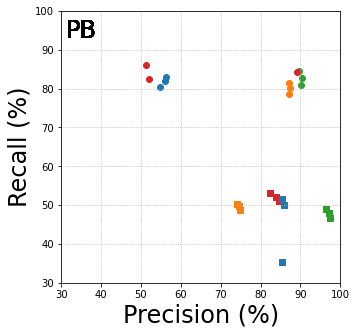

In [17]:
markers = ["s", "s", "s", "s", "s", "s", "s", "s", "s", "s", "s", "s", 
           "o", "o", "o", "o", "o", "o", "o", "o", "o", "o", "o", "o"]
colors = ['tab:green', 'tab:green', 'tab:green', 'tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:orange',
          'tab:green', 'tab:green', 'tab:green', 'tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:orange']

for i in range(24): #for each of the 7 features 
    mi = markers[i] #marker for ith feature 
    xi = precision_recall_df_MC.precision[i] #x array for ith feature .. here is where you would generalize      different x for every feature
    yi = precision_recall_df_MC.recall[i] #y array for ith feature 
    ci = colors[i] #color for ith feature 
    plt.rcParams["figure.figsize"] = (5,5)
    plt.scatter(xi,yi,marker=mi,color=ci) 
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Precision (%)', fontsize=24)
    plt.ylabel('Recall (%)', fontsize=24)
    plt.xlim([30, 100])
    plt.ylim([30, 100])
    ax = plt.gca()
    ax.xaxis.grid(linestyle='dotted')
    ax.yaxis.grid(linestyle='dotted')
    ax.text(31, 93, 'PB', fontweight=300, fontsize=24)
    plt.savefig(os.path.join(basedir, 'Figure3A_2.png'), dpi=1000)
plt.show() 


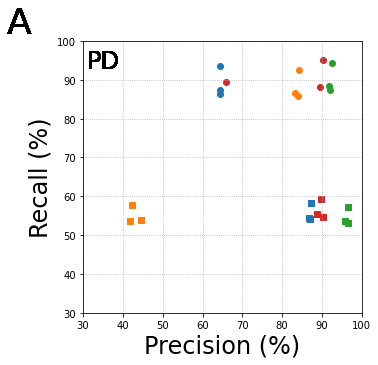

In [18]:
for i in range(24): #for each of the 7 features 
    mi = markers[i] #marker for ith feature 
    xi = precision_recall_df_IE.precision[i] #x array for ith feature .. here is where you would generalize      different x for every feature
    yi = precision_recall_df_IE.recall[i] #y array for ith feature 
    ci = colors[i] #color for ith feature 
    plt.rcParams["figure.figsize"] = (5,5)
    plt.scatter(xi,yi,marker=mi,color=ci) 
    plt.xlabel('Precision (%)', fontsize=24)
    plt.ylabel('Recall (%)', fontsize=24)
    plt.xlim([30, 100])
    plt.ylim([30, 100])
    ax = plt.gca()
    ax.xaxis.grid(linestyle='dotted')
    ax.yaxis.grid(linestyle='dotted')
    ax.text(31, 93, 'PD', fontweight=300, fontsize=24)
    ax.text(11, 102, 'A', fontweight=300, fontsize=36)
    plt.savefig(os.path.join(basedir, 'Figure3A_1.png'), dpi=1000)
plt.show() 

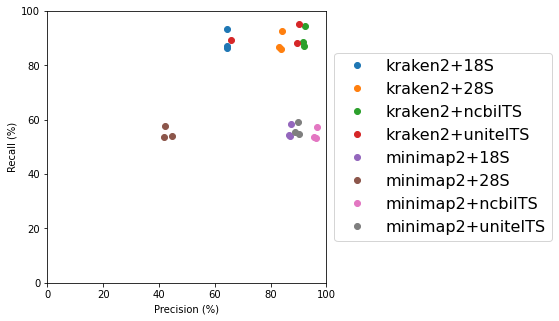

In [19]:
# This is used to plot the figure legends
groups = precision_recall_df_IE.groupby("category")
for name, group in groups:
    plt.plot(group['precision'], group['recall'], marker='o', linestyle='', label=name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
    plt.xlabel('Precision (%)')
    plt.ylabel('Recall (%)')
    plt.xlim([0, 100])
    plt.ylim([0, 100])
plt.savefig(os.path.join(basedir, 'Figure3A_legend_1.png'),bbox_inches='tight', dpi=1000)

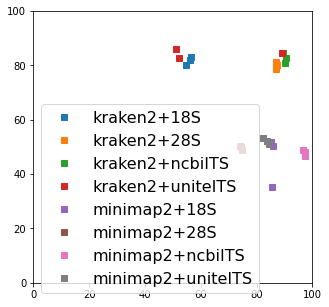

In [20]:
# This is used to plot the figure legends
groups = precision_recall_df_MC.groupby("category")
for name, group in groups:

    plt.plot(group['precision'], group['recall'], marker='s', linestyle='', label=name)
    plt.legend(loc='center left', bbox_to_anchor=(0, 0.31), fontsize=16)
    plt.xlim([0, 100])
    plt.ylim([0, 100])
    plt.savefig(os.path.join(basedir, 'Figure3A_legend_2.png'), dpi=1000)

In [21]:
# This function is for ploting Figure3C which is in another script, and that script also didn't use it.
# I just put it here as I think we should use this script to calculate the completeness rather than copy the numbers straightway.
def calculate_completeness(barcode, db, algorithm):
    tab_df = get_tab_df(barcode, db, algorithm)
    if algorithm == 'k2':
        return len(tab_df[tab_df.genus_k2.isin(genera_in_mock)].genus_k2.unique())/len(genera_in_mock)
    elif algorithm == 'minimap':
        return len(tab_df[tab_df.genus.isin(genera_in_mock)].genus.unique())/len(genera_in_mock)
    else:
        print('Wrong algorithm. Chose from k2 or minimap')
    

In [22]:
tab_df = pd.concat([get_tab_df('01', 'unite99ITS', 'minimap'), get_tab_df('05', 'unite99ITS', 'minimap'), get_tab_df('09', 'unite99ITS', 'minimap')],ignore_index=True)

In [23]:
IE1_tab = get_tab_df('01', 'unite99ITS', 'minimap')
IE2_tab = get_tab_df('05', 'unite99ITS', 'minimap')
IE3_tab = get_tab_df('09', 'unite99ITS', 'minimap')
MC1_tab = get_tab_df('02', 'unite99ITS', 'minimap')
MC2_tab = get_tab_df('06', 'unite99ITS', 'minimap')
MC3_tab = get_tab_df('10', 'unite99ITS', 'minimap')

In [25]:
# This is to verify that this script works the same as mannual calculation
calculate_completeness('10', 'unite99ITS', 'minimap')

0.625

In [24]:
len(MC3_tab[MC3_tab.genus.isin(genera_in_mock)].genus.unique())/len(genera_in_mock)

0.625